# Initial conditions of (cored) powerlaw profiles with non-uniform mass

This is a minimal example of how to set up ICs of a (cored) powerlaw profile with varying mass resolution

In [1]:
%matplotlib inline
import numpy as np
import sys

sys.path.append("../../cusp-encounters")
sys.path.append("../../cusp-encounters/adiabatic-tides")
import adiabatic_tides as at
import matplotlib.pyplot as plt

import cusp_encounters.cored_powerlaw as cored_powerlaw

In [2]:
# The IC generation depends on the adiabatic-tides code, which uses as unit system
# lengths : Mpc
# masses : Msol
# velocities : km/s
# So we have to multiply A e.g. by 1e9 to get from Msol/pc**1.5 to Msol/Mpc**1.5
A     = 1e-4 * 1e9  # Msol/Mpc**1.5
rcore = 1e-5 * 1e-6 # Mpc

cprof = cored_powerlaw.PhasespaceTruncatedCusp(rcore=rcore, A=A, rmin=rcore*1e-11, rmax=rcore*1e22) # rmin and rmax are just relevant for numerics

# We can create a pure powerlaw profile by using rcore -> 0
pprof = cored_powerlaw.PhasespaceTruncatedCusp(rcore=rcore*1e-3, A=A, rmin=rcore*1e-11, rmax=rcore*1e22) # rmin and rmax are just relevant for numerics

# Sample particles for the cored case

In [3]:
%%time
rsplits = np.array((0.,1.,10.,100.,1000.,10000.)) * rcore
pos, vel, mass = cprof.sample_particles_rperisplits(npersplit=40000, rsplits=rsplits, seed=42, flatten=False)

print(pos.shape, vel.shape, mass.shape)

../../cusp-encounters/adiabatic-tides/adiabatic_tides/profiles.py:1649: RuntimeWarning: divide by zero encountered in log10
  dphi = np.interp(np.log10(r), np.log10(self.rbins), self.q["phi"])


(5, 40000, 3) (5, 40000, 3) (5, 40000)
CPU times: user 4.89 s, sys: 30.8 ms, total: 4.93 s
Wall time: 4.94 s


In [4]:
def population_plot(pos, mass, cored=True, labels=None, **kwargs):
    nsplits = len(pos)
    
    if cored:
        prof = cprof
    else:
        prof = pprof
    
    rbins = np.logspace(-2,5, 101) * rcore
    ri = np.sqrt(rbins[1:] * rbins[:-1])
    
    def get_rho(pos, mass):
        mi,_ = np.histogram(np.linalg.norm(pos, axis=-1), bins=rbins, weights=mass)
        vi = 4.*np.pi/3. * (rbins[1:]**3 - rbins[:-1]**3)

        return mi/vi
    
    label = None
    
    rho = [get_rho(pos[i], mass[i]) for i in range(0, nsplits)]
    
    for i in range(0, nsplits):
        m0 = np.mean(mass[0,0])
        label = r"$M = %.0f M_{\rm{hr}}$" % np.mean(mass[i,0]/m0)
        
        axs[0].loglog(ri/rcore, rho[i], color="C%d" % i, label=label, **kwargs)
        axs[1].semilogx(ri/rcore, rho[i]/(prof.density(ri)), color="C%d" % i, label=label, **kwargs)
        
    axs[0].loglog(ri/rcore, np.sum(rho, axis=0), color="black", label="sum", **kwargs)
    axs[1].semilogx(ri/rcore, np.sum(rho, axis=0)/prof.density(ri), color="black", label="sum", **kwargs)

    for ax in axs:
        ax.set_xlim(1e-1,2e4)

    axs[0].set_ylim(1e15, 2e22)
    axs[1].set_ylim(0,2)

Text(0.5, 0, '$r / r_{\\rm{core}}$')

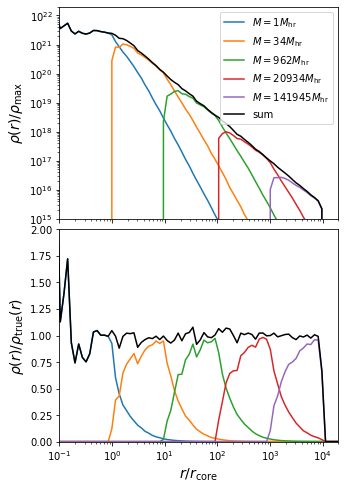

In [5]:
fig, axs = plt.subplots(2,1, figsize=(5, 8), sharex=True)
fig.subplots_adjust(hspace=0.05)

population_plot(pos, mass, cored=True)

axs[0].legend(loc="upper right")

axs[0].set_ylabel(r"$\rho(r) / \rho_{\rm{max}}$", fontsize=14)
axs[1].set_ylabel(r"$\rho(r) / \rho_{\rm{true}}(r)$", fontsize=14)
axs[1].set_xlabel(r"$r / r_{\rm{core}}$", fontsize=14)

# Sampling the Powerlaw

In [6]:
rsplits = np.array((0.,1.,10.,100.,1000.,10000.)) * rcore
pos2, vel2, mass2 = pprof.sample_particles_rperisplits(npersplit=40000, rsplits=rsplits, seed=42, flatten=False)

../../cusp-encounters/adiabatic-tides/adiabatic_tides/profiles.py:1649: RuntimeWarning: divide by zero encountered in log10
  dphi = np.interp(np.log10(r), np.log10(self.rbins), self.q["phi"])


Text(0.5, 0, '$r / r_{\\rm{core}}$')

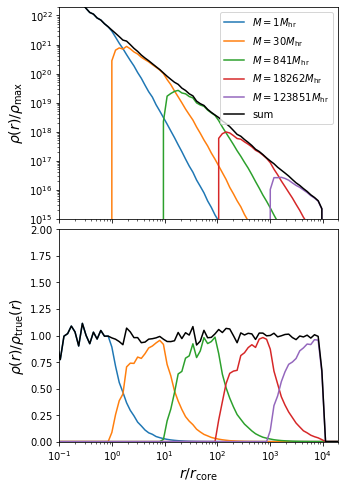

In [7]:
fig, axs = plt.subplots(2,1, figsize=(5, 8), sharex=True)
fig.subplots_adjust(hspace=0.05)

population_plot(pos2, mass2, cored=False)

axs[0].legend(loc="upper right")

axs[0].set_ylabel(r"$\rho(r) / \rho_{\rm{max}}$", fontsize=14)
axs[1].set_ylabel(r"$\rho(r) / \rho_{\rm{true}}(r)$", fontsize=14)
axs[1].set_xlabel(r"$r / r_{\rm{core}}$", fontsize=14)

# IC Files

In general you will have to write your own code for writing out the particle data into an initial conditions file. 

However, if you are using Go Ogiya's gputree code, you can use the function "cored_powerlaw.write_gputree_ic_splitted"